In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nelpy as nel
import pandas as pd
import pandas
import os

/usr/lib/python3/dist-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [181]:
LogFileDirs = ['ExperimentLog2020-07-16_1640_M32_ses1',
    'ExperimentLog2020-07-16_1701_SvF2_ses1',
    'ExperimentLog2020-07-17_1436_M32_ses1',
    'ExperimentLog2020-07-17_1629_SvF2_ses1']


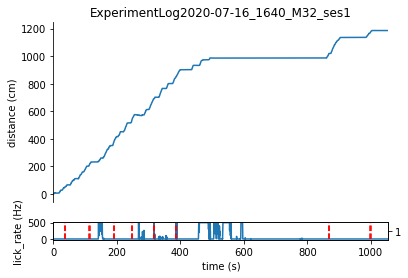

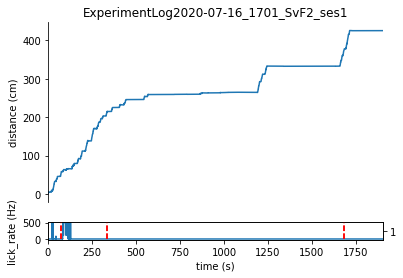

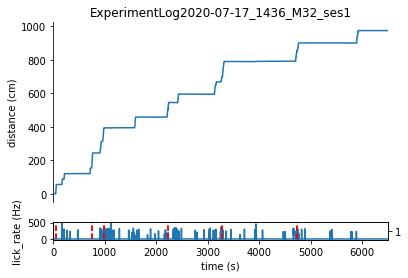

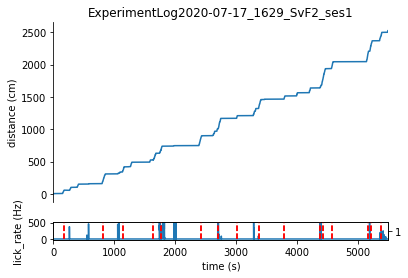

In [214]:
for LogFileDir in LogFileDirs:
    LogFileName = os.path.join(LogFileDir, 'DataLog.csv')
    ConfigFileName = os.path.join(LogFileDir, 'ParsedConfig.yaml')

    with open(ConfigFileName, 'r') as f:
        Config = yaml.safe_load(f)

    data_log = pd.read_csv(LogFileName, header=2, names=['ts_master', 'GPIO', 'encoder', 'encoder_unwrapped', 'ts_sys'])


    pos = ((data_log.encoder_unwrapped - data_log.encoder_unwrapped[0])/4096.0 * np.pi * 20.2).to_numpy()
    t = ((data_log.ts_master - data_log.ts_master[0])/1000).to_numpy()
    virtual_track_position = nel.Ordinate(labelstring='distance ({})', base_unit='cm')
    pos_data = nel.AnalogSignalArray(data=pos, time=t, ordinate=virtual_track_position)


    def extract_gpio(data, config):
        gpio_data = {}
        for key, value in config['GPIO'].items():
            gpio_data[key] = np.bitwise_and(data, 2**(value['Number']-1)) > 0

        return gpio_data

    gpio = extract_gpio(data_log.GPIO.to_numpy(), Config)
    reward_times = t[np.nonzero(np.diff(gpio['Reward'])==1)[0] + 1]
    reward_data = nel.SpikeTrainArray(reward_times, fs=500, support=pos_data.support)

    lick_data = nel.SpikeTrainArray(t[np.nonzero(gpio['Lick'])], fs=500, support=pos_data.support)
    lick_rate = nel.AnalogSignalArray(lick_data.bin(ds=0.25)/0.25, 
                                            ordinate=nel.Ordinate(labelstring='lick_rate ({})', base_unit='Hz'))
    fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [10, 1]})
    nel.plotting.plot(pos_data, ax=ax[0], xlabel='')
    nel.plotting.utils.clear_top_bottom(ax[0])
    nel.plotting.utils.clear_right(ax[0])
    ax[0].set_title('{}'.format(LogFileDir))
    ax[0].set_xlabel('')
    ax2 = plt.twinx(ax[1])
    nel.plotting.plot(lick_rate, ax=ax[1])
    nel.plotting.rasterplot(reward_data, ax=ax2, color='r', linestyle='--')


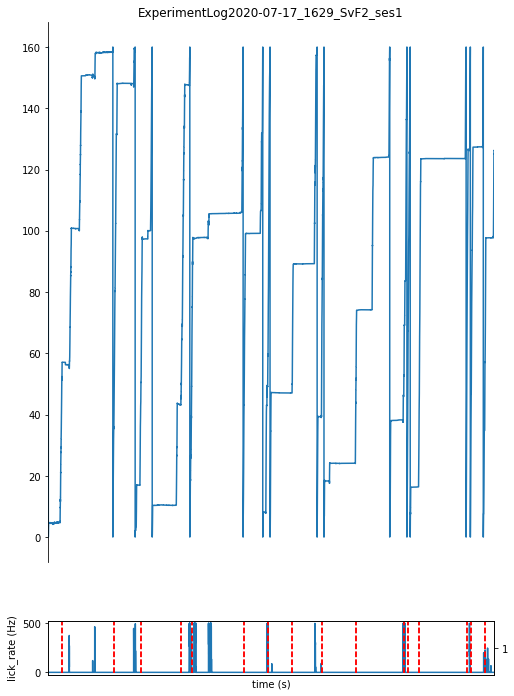

In [236]:
fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [10, 1]}, figsize=(8,12), sharex=True)
ax[0].plot(pos_data.abscissa_vals, np.mod(pos_data.data.squeeze(), Config['Maze']['Length']))
nel.plotting.utils.clear_top_bottom(ax[0])
nel.plotting.utils.clear_right(ax[0])
ax[0].set_title('{}'.format(LogFileDir))
ax[0].set_xlabel('')
ax2 = plt.twinx(ax[1])
nel.plotting.plot(lick_rate, ax=ax[1])
nel.plotting.rasterplot(reward_data, ax=ax2, color='r', linestyle='--')


(4200, 4600)

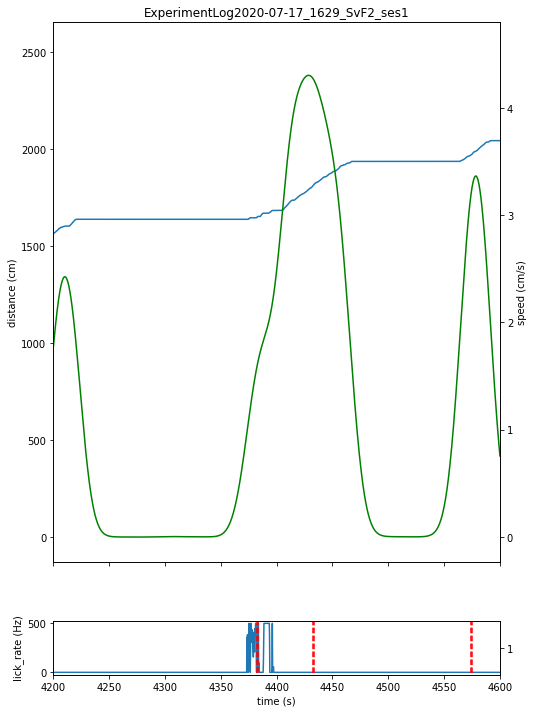

In [254]:
fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [10, 1]}, figsize=(8,12), sharex=True)
pos_data_ds = pos_data.downsample(fs_out=10)
nel.plotting.plot(pos_data_ds, ax=ax[0])
ax1 = plt.twinx(ax[0])
nel.plotting.plot(nel.utils.ddt_asa(pos_data_ds, smooth=True, sigma=10), ax=ax1, color='g')
ax[0].set_title('{}'.format(LogFileDir))
ax[0].set_xlabel('')
ax1.set_ylabel('speed (cm/s)')
ax2 = plt.twinx(ax[1])
nel.plotting.plot(lick_rate, ax=ax[1])
nel.plotting.rasterplot(reward_data, ax=ax2, color='r', linestyle='--')
ax[0].set_xlim(4200,4600)

In [245]:
p2 = pos_data.downsample(fs_out=10)